In [1]:
import os
import numpy as np
import argparse
import numbers
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.transforms.functional import normalize

from matplotlib import pyplot as plt

import models
import criterion
import utils
from utils import ext_transforms as et
from utils.nerve import Nerve

import numpy as np
import argparse
import numbers
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.transforms.functional import normalize

from matplotlib import pyplot as plt

import models
import criterion
from utils import ext_transforms as et
from utils.nerve import Nerve
from utils.totalnerve import TotalNerve
from utils.partnerve import PartNerve
from utils.busi import BUSI
from utils.utils import Params


args = {
    "param_ckpt" : "/",
    "dst_pth" : "/home/dongik/src/cpn-TMP640-result/Nov07-20-07-56",
    "data_pth" : "/home/dongik/datasets",
    "num_workers" : 8,
    "modality" : "UN",
    "region" : "BUSI_with_GT",
    "kfold" : 5,
    "k" : 0,
    "batch_size" : 16,
}
opts = Params(json_path=os.path.join(args['dst_pth'], 'param-summary.json'))
args['batch_size'] = opts.val_batch_size
args['param_ckpt'] = os.path.join(opts.BP_pth, f"run_00/fold_0{args['k']}")

class Denormalize(object):
    def __init__(self, mean, std):
        mean = np.array(mean)
        std = np.array(std)
        self._mean = -mean/std
        self._std = 1/std

    def __call__(self, tensor):
        if isinstance(tensor, np.ndarray):
            return (tensor - self._mean.reshape(-1,1,1)) / self._std.reshape(-1,1,1)
        return normalize(tensor, self._mean, self._std)
denorm = Denormalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

def cmap(N=4, preds=False):

        color_map = np.zeros((N, 3), dtype='uint8')
        color_map[0] = np.array([255, 255, 255])
        color_map[1] = np.array([204, 0, 0]) if preds else np.array([0, 0, 204])
        color_map[2] = np.array([255, 102, 102]) if preds else np.array([102, 102, 255])
        color_map[3] = np.array([0, 51, 0]) if preds else np.array([0, 255, 0])

        return color_map

def get_pnt(pnt, crop_size):
    # Height
    if pnt[0] >= crop_size[0]/2 and (1024 - pnt[0]) >= crop_size[0]/2:
        lt = (int(pnt[0] - crop_size[0]/2), 0)
        rb = (int(pnt[0] + crop_size[0]/2), 0)
    elif pnt[0] < crop_size[0]/2 and (1024 - pnt[0]) >= crop_size[0]/2:
        lt = (0, 0)
        rb = (crop_size[0], 0)
    elif pnt[0] >= crop_size[0]/2 and (1024 - pnt[0]) < crop_size[0]/2:
        lt = (1024 - crop_size[0], 0)
        rb = (1024, 0)
    lt = list(lt)
    rb = list(rb)
    # Width
    if pnt[1] >= crop_size[1]/2 and (1024 - pnt[1]) >= crop_size[1]/2:
        lt[1] = int(pnt[1] - crop_size[1]/2)
        rb[1] = int(pnt[1] + crop_size[1]/2)
    elif pnt[1] < crop_size[1]/2 and (1024 - pnt[1]) >= crop_size[1]/2:
        lt[1] = 0
        rb[1] = crop_size[1]
    elif pnt[1] >= crop_size[1]/2 and (1024 - pnt[1]) < crop_size[1]/2:
        lt[1] = 1024 - crop_size[1]
        rb[1] = 1024

    return lt, rb

def show(ims, mas, bbox, outputs, pmas, crop_size=256, save=False, verbose=False):
    """ 
    Args:
        ims (Tensor)
    """
    if isinstance(crop_size, numbers.Number):
        crop_size = (int(crop_size), int(crop_size))
    else:
        crop_size = crop_size
    pcmap = cmap(preds=True)
    tcmap = cmap(preds=False)

    for i in range(ims.size()[0]):
        tar = (denorm(ims[i].numpy()) * 255).transpose(1, 2, 0).astype(np.uint8)

        mtar = torch.zeros(mas[0].shape, 
                    device='cpu', dtype=torch.long, )

        true_anchor = ((bbox[i].numpy() * 1024) + 512).astype(np.int32)
        pred_anchor = ((outputs[i].numpy() * 1024) + 512).astype(np.int32)

        print(ims[i].size(), mtar.size())
        print(true_anchor, pred_anchor)

        mtar[pmas[i] > 0] = 1
        mtar[mas[i] > 0] += 2
        mtar = pcmap[mtar.numpy()]

        # pred
        lt, rb = get_pnt(pred_anchor, crop_size)
        pmas[i, lt[0]:rb[0], lt[1]:lt[1]+3] = 2
        pmas[i, lt[0]:rb[0], rb[1]-3:rb[1]] = 2
        pmas[i, lt[0]:lt[0]+3, lt[1]:rb[1]] = 2
        pmas[i, rb[0]-3:rb[0], lt[1]:rb[1]] = 2
        pmas[i, pred_anchor[0]-3:pred_anchor[0]+3, pred_anchor[1]-30:pred_anchor[1]+30] = 2
        pmas[i, pred_anchor[0]-30:pred_anchor[0]+30, pred_anchor[1]-3:pred_anchor[1]+3] = 2
        ptar = pcmap[pmas[i].numpy()]

        # true
        lt, rb = get_pnt(true_anchor, crop_size)
        mas[i, lt[0]:rb[0], lt[1]:lt[1]+3] = 2
        mas[i, lt[0]:rb[0], rb[1]-3:rb[1]] = 2
        mas[i, lt[0]:lt[0]+3, lt[1]:rb[1]] = 2
        mas[i, rb[0]-3:rb[0], lt[1]:rb[1]] = 2
        mas[i, true_anchor[0]-3:true_anchor[0]+3, true_anchor[1]-30:true_anchor[1]+30] = 2
        mas[i, true_anchor[0]-30:true_anchor[0]+30, true_anchor[1]-3:true_anchor[1]+3] = 2
        ttar = tcmap[mas[i].numpy()]

        
        plt.figure(figsize=(20, 5))
        plt.subplot(1, 4, 1)
        plt.imshow(tar,)
        plt.subplot(1, 4, 2)
        plt.imshow(ttar, )
        plt.subplot(1, 4, 3)
        plt.imshow(ptar, )
        plt.subplot(1, 4, 4)
        plt.imshow(mtar, )
        plt.show()
        
        if save:
            ...
        if i == 5:
            break

def _show(ims, mas, ):
    cmp = cmap(preds=True)
    for i in range(ims.size()[0]):
        tar = (denorm(ims[i].numpy()) * 255).transpose(1, 2, 0).astype(np.uint8)
        mtar = cmp[mas[i, ...].numpy()]
        plt.subplot(1, 2, 1)
        plt.imshow(tar, cmap='gray')
        plt.subplot(1, 2, 2)
        plt.imshow(mtar, cmap='gray')
        plt.show()


def crop(ims, mas, anchor, devices, crop_size=256):
    if isinstance(crop_size, numbers.Number):
        crop_size = (int(crop_size), int(crop_size))
    else:
        crop_size = crop_size
    
    cims = torch.zeros((ims.shape[0], 3, crop_size[0], crop_size[1]), 
                        device=devices, dtype=ims.dtype, )
    cmas = torch.zeros((mas.shape[0], crop_size[0], crop_size[1]), 
                        device=devices, dtype=torch.long,)
    
    anchor = ((anchor * 1024) + 512).type(torch.int32)
    
    for i in range(ims.size()[0]):

        lt, rb = get_pnt(anchor[i], crop_size)
        if i == 0:
            print(f"lt: {lt}, rb: {rb}")
        cims[i, ...] = ims[i, ...][... , lt[0]:rb[0], lt[1]:rb[1]]
        cmas[i, ...] = mas[i, ...][lt[0]:rb[0], lt[1]:rb[1]]
        
    return cims, cmas

def recover(mas, cmas, anchor, devices, crop_size=(256, 256)):
    anchor = ((anchor * 1024) + 512).type(torch.int32)
    result = torch.zeros(mas.shape, 
                        device=devices, dtype=torch.long, )
    for i in range(mas.size()[0]):
        if i == 0:
            print(f"anchor[0]: {anchor[i]}")
        lt, rb = get_pnt(anchor[i], crop_size)
        result[i, ...][lt[0]:rb[0], lt[1]:rb[1]] = cmas[i, ...]
    
    return result

devices = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

norm = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
transform = et.ExtCompose([
    et.ExtToTensor(),
    et.ExtNormalize(mean=norm[0], std=norm[1]),
    ])
    
dst = BUSI(root_pth=args['data_pth'], datatype=args['region'], lesions='benign', 
                        fold=f"v{args['kfold']}/{args['k']}", image_set='val', transform=transform, )

loader = DataLoader(dst, batch_size=args['batch_size'], 
                        num_workers=args['num_workers'], shuffle=True, drop_last=True)

print("Dataset - %s\n\tTest\t%d" % 
        (f"v{args['kfold']}/{args['k']}" + '/' + args['region'], len(dst) ))

/home/dongik/.conda/envs/CPNKDv5/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset - v5/0/BUSI_with_GT
	Test	88


In [2]:
print(f"Seg: {opts.model}, Backbone: {opts.backbone}")

net = models.models.__dict__[opts.model](opts, )
ckpt = torch.load(os.path.join(args['param_ckpt'], 'checkpoint.pt'), map_location='cpu')
net = nn.DataParallel(net)
net.load_state_dict(ckpt["model_state"])
net.to(devices)
print(f'Seg best epoch: { ckpt["cur_epoch"] }')

backbone = models.models.__dict__[opts.backbone](opts, )
ckpt = torch.load(os.path.join(args['param_ckpt'], 'backbone.pt'), map_location='cpu')
#ckpt = {k.partition('model.')[-1]: v for k,v in ckpt}
backbone = nn.DataParallel(backbone)
backbone.load_state_dict(ckpt["model_state"])
backbone.to(devices)
print(f'Backbone best epoch: { ckpt["cur_epoch"] }')

Seg: deeplabv3plus_resnet50, Backbone: backbone_vit
Seg best epoch: 71
Backbone best epoch: 71


  0%|          | 0/22 [00:00<?, ?it/s]

lt: [151, 239], rb: [663, 751]
crop images, masks size:  torch.Size([4, 3, 512, 512]) torch.Size([4, 512, 512])
anchor[0]: tensor([407, 495], device='cuda:0', dtype=torch.int32)
torch.Size([3, 1024, 1024]) torch.Size([1024, 1024])
[399 684] [407 495]


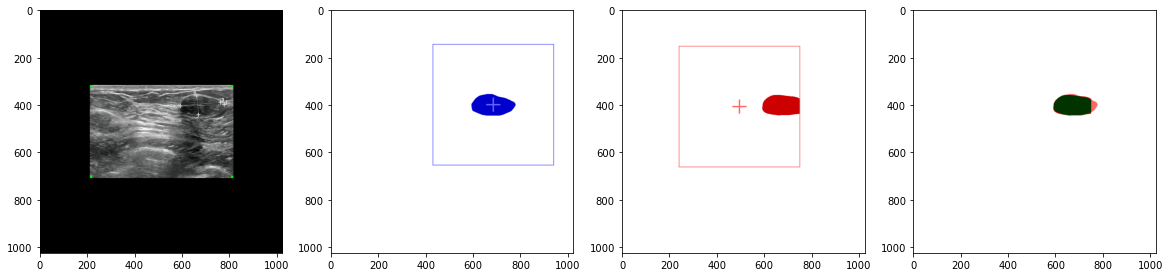

torch.Size([3, 1024, 1024]) torch.Size([1024, 1024])
[390 466] [409 496]


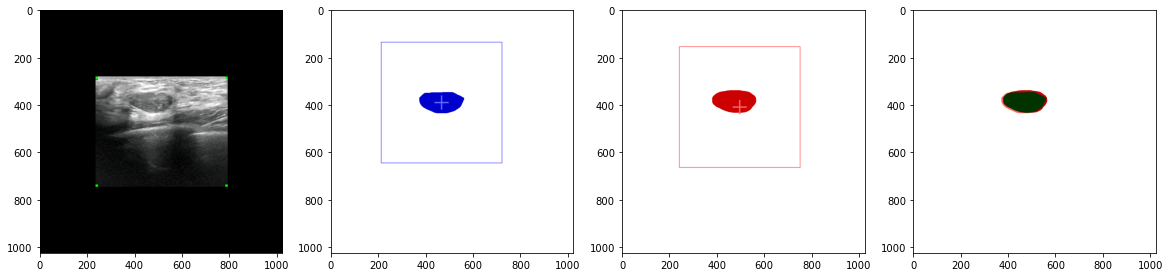

torch.Size([3, 1024, 1024]) torch.Size([1024, 1024])
[309 771] [405 493]


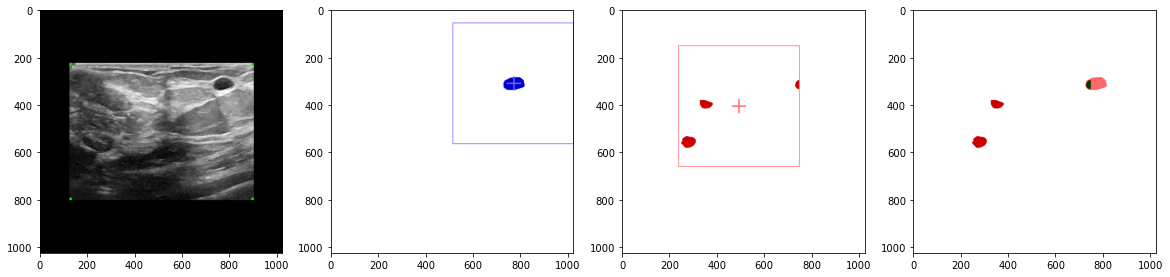

torch.Size([3, 1024, 1024]) torch.Size([1024, 1024])
[354 485] [410 494]


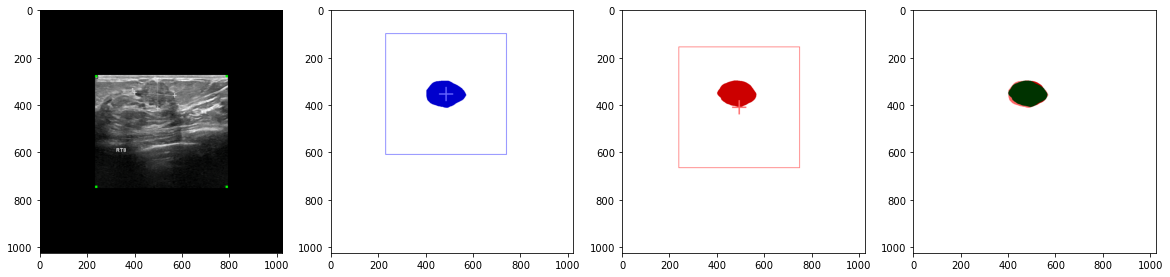

  5%|▍         | 1/22 [00:15<05:25, 15.52s/it]

lt: [155, 238], rb: [667, 750]
anchor[0]: tensor([411, 494], device='cuda:0', dtype=torch.int32)


 14%|█▎        | 3/22 [00:16<01:12,  3.79s/it]

lt: [148, 237], rb: [660, 749]
anchor[0]: tensor([404, 493], device='cuda:0', dtype=torch.int32)
lt: [143, 237], rb: [655, 749]
anchor[0]: tensor([399, 493], device='cuda:0', dtype=torch.int32)


 18%|█▊        | 4/22 [00:16<00:44,  2.46s/it]

lt: [150, 241], rb: [662, 753]
anchor[0]: tensor([406, 497], device='cuda:0', dtype=torch.int32)


 23%|██▎       | 5/22 [00:17<00:30,  1.78s/it]

lt: [153, 240], rb: [665, 752]
anchor[0]: tensor([409, 496], device='cuda:0', dtype=torch.int32)


 27%|██▋       | 6/22 [00:17<00:21,  1.31s/it]

lt: [152, 239], rb: [664, 751]
anchor[0]: tensor([408, 495], device='cuda:0', dtype=torch.int32)


 32%|███▏      | 7/22 [00:18<00:15,  1.03s/it]

lt: [153, 239], rb: [665, 751]
anchor[0]: tensor([409, 495], device='cuda:0', dtype=torch.int32)


 36%|███▋      | 8/22 [00:18<00:11,  1.20it/s]

lt: [148, 241], rb: [660, 753]
anchor[0]: tensor([404, 497], device='cuda:0', dtype=torch.int32)


 41%|████      | 9/22 [00:19<00:09,  1.40it/s]

lt: [148, 238], rb: [660, 750]
anchor[0]: tensor([404, 494], device='cuda:0', dtype=torch.int32)


 45%|████▌     | 10/22 [00:19<00:07,  1.61it/s]

lt: [154, 239], rb: [666, 751]
anchor[0]: tensor([410, 495], device='cuda:0', dtype=torch.int32)


 50%|█████     | 11/22 [00:19<00:06,  1.77it/s]

lt: [152, 237], rb: [664, 749]
anchor[0]: tensor([408, 493], device='cuda:0', dtype=torch.int32)


 55%|█████▍    | 12/22 [00:20<00:05,  1.92it/s]

lt: [156, 239], rb: [668, 751]
anchor[0]: tensor([412, 495], device='cuda:0', dtype=torch.int32)


 59%|█████▉    | 13/22 [00:20<00:04,  2.02it/s]

lt: [147, 236], rb: [659, 748]
anchor[0]: tensor([403, 492], device='cuda:0', dtype=torch.int32)


 64%|██████▎   | 14/22 [00:21<00:03,  2.12it/s]

lt: [154, 239], rb: [666, 751]
anchor[0]: tensor([410, 495], device='cuda:0', dtype=torch.int32)


 68%|██████▊   | 15/22 [00:21<00:03,  2.16it/s]

lt: [155, 238], rb: [667, 750]
anchor[0]: tensor([411, 494], device='cuda:0', dtype=torch.int32)


 73%|███████▎  | 16/22 [00:22<00:02,  2.23it/s]

lt: [152, 236], rb: [664, 748]
anchor[0]: tensor([408, 492], device='cuda:0', dtype=torch.int32)


 77%|███████▋  | 17/22 [00:22<00:02,  2.24it/s]

lt: [153, 240], rb: [665, 752]
anchor[0]: tensor([409, 496], device='cuda:0', dtype=torch.int32)


 86%|████████▋ | 19/22 [00:23<00:01,  2.31it/s]

lt: [154, 239], rb: [666, 751]
anchor[0]: tensor([410, 495], device='cuda:0', dtype=torch.int32)


 91%|█████████ | 20/22 [00:23<00:00,  2.40it/s]

lt: [154, 238], rb: [666, 750]
anchor[0]: tensor([410, 494], device='cuda:0', dtype=torch.int32)


 95%|█████████▌| 21/22 [00:24<00:00,  2.42it/s]

lt: [155, 239], rb: [667, 751]
anchor[0]: tensor([411, 495], device='cuda:0', dtype=torch.int32)


100%|██████████| 22/22 [00:24<00:00,  2.47it/s]

lt: [155, 241], rb: [667, 753]
anchor[0]: tensor([411, 497], device='cuda:0', dtype=torch.int32)


100%|██████████| 22/22 [00:24<00:00,  1.12s/it]

Epoch loss : 0.228935, 0.007191
Score : {'Overall Acc': 0.9931481751528654, 'Mean Acc': 0.899059811685585, 'FreqW Acc': 0.9871450856531567, 'Mean IoU': 0.8490464654653093, 'Class IoU': {0: 0.9930340779846125, 1: 0.705058852946006}, 'Class F1': {0: 0.9965048655753886, 1: 0.827019960897893}}


In [3]:
running_loss = [0.0, 0.0]
mse = criterion.get_criterion.__dict__['mseloss']()
dice = criterion.get_criterion.__dict__[opts.loss_type]()
metrics = utils.StreamSegMetrics(n_classes=2)
metrics.reset()

with torch.no_grad():
    for i, (ims, lbls) in tqdm(enumerate(loader), total=len(loader)):
        
        backbone.eval()
        net.eval()

        ims = ims.to(devices)
        mas = lbls[0].to(devices)
        bbox = lbls[1].to(devices)

        anchor = backbone(ims)
        mse_loss = mse(anchor, bbox)

        cims, cmas = crop(ims, mas, anchor, devices, crop_size=512)
        if i == 0:
            print('crop images, masks size: ', cims.size(), cmas.size())
        
        outputs = net(cims)
        probs = nn.Softmax(dim=1)(outputs)
        preds = recover(mas, torch.max(probs, 1)[1], anchor, devices, crop_size=(512, 512))

        dice_loss = dice(outputs, cmas)
        metrics.update(mas.detach().cpu().numpy(), preds.detach().cpu().numpy())

        running_loss[1] += (mse_loss.item() * ims.size(0))
        running_loss[0] += (dice_loss.item() * ims.size(0))

        #show(ims.detach().cpu(), mas.detach().cpu(), bbox.detach().cpu(), anchor.detach().cpu())
        if i == 0:
            show(ims.detach().cpu(), mas.detach().cpu(), bbox.detach().cpu(), anchor.detach().cpu(), preds.detach().cpu(), crop_size=(512, 512))
        #
        #_show(cims.detach().cpu(), cmas.detach().cpu())

        #_show(ims.detach().cpu(), result.detach().cpu())
        #print(f'{running_loss:.6f}, {mse_loss.item()}, {ims.size(0)}')
    #print(f'running loss : {running_loss:.6f} / {len(loader)}')
    epoch_loss = [running_loss[0] / len(loader.dataset), running_loss[1] / len(loader.dataset)]

print(f"Epoch loss : {epoch_loss[0]:.6f}, {epoch_loss[1]:.6f}")
print(f"Score : {metrics.get_results()}")

In [2]:
import numpy as np
import cv2 as cv
from PIL import Image

kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (7, 7)).transpose()
print(f'kernel: {type(kernel)}\n{kernel}')

mask = Image.open('/home/dongik/datasets/median-wrist-d/HM/Masks/0000000.bmp').convert('L')
mask = np.array(mask)
print(f'mask shape: {mask.shape}')

print('Before')
plt.imshow(mask, cmap='gray')
plt.show()

dilation = cv.dilate(mask, kernel, iterations=1)
dilation[np.where(np.array(dilation) < 255)] = 0

Image.fromarray(dilation).save('/home/dongik/sample.bmp')

print('After')
plt.imshow(dilation, cmap='gray')
plt.show()

dilation[176:190, 217:240]

kernel: <class 'numpy.ndarray'>
[[0 0 1 1 1 0 0]
 [0 1 1 1 1 1 0]
 [0 1 1 1 1 1 0]
 [1 1 1 1 1 1 1]
 [0 1 1 1 1 1 0]
 [0 1 1 1 1 1 0]
 [0 0 1 1 1 0 0]]
mask shape: (640, 640)
Before


NameError: name 'plt' is not defined

(640, 640)


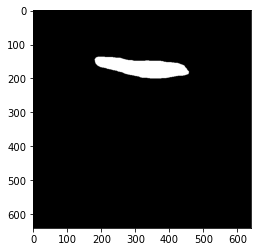

array([[255, 255, 255, 255, 255, 255, 255, 255, 255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255],
       [255, 255, 255, 255, 255, 255, 255, 255, 255, 255]], dtype=uint8)

In [31]:
mask = Image.open('/home/dongik/datasets/peroneal/UN/Masks/FH_I0000677.bmp').convert('L')
mask = np.array(mask)
print(mask.shape)
#mask[np.where(np.array(mask) > 0)] = 255

plt.imshow(mask, cmap='gray')
plt.show()

np.where(mask > 0)
mask[137:147, 190:200]

In [25]:
Image.open('/home/dongik/datasets/median-wrist/HM/Masks/0000000.jpg').save('/home/dongik/sample.bmp')